## Projeto 2 Modelagem matemático-computacional - 2º semestre 2020, Professor Luciano da F. Costa 

### Otimização por busca aleatória, Descida de gradiente, e simulated annealing 


### Método da busca aleatória

A busca aleatória, como seu nome diz, baseia-se em chutar valores para o domínio da função e calcular o valor correspondente. Iniciamos uma variável $F_{min}$ e a cada iteração chutamos valores para as variáveis e checamos se o valor da função nesse ponto dado pelo chute é maior ou menor, caso seja menor atualizamos $F_{min}$. Para o nosso caso, seja $$g(x,y) = x^2 + y^2 $$ e $(-1,-1) < (x,y) < (1,1)$. 

O algoritmo a cada atualização sorteia um número real $(x_r,y_r)$ e efetua o calculo de $g(x_r,y_r)$, caso esse valor seja menor que o mínimo encontrado até então, atualizamos.
Os parâmetros da nossa função random_search consiste nos limites do dominio $x_{lim}$ e $y_{lim}$, o número de simulações a serem feitas $n_{sim}$, número de iterações $n_{times}$ e a função que iremos calcular o mínimo, retornando a média de cada iteração e seu desvio padrão.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# random search 
## Input :
## * xlim -> vetor [xmin,xmax]
## * ylim -> vetor [ymin,ymax]
## * nsim -> # de simulações a serem calculadas
## * ntimes -> # de iterações para cada simulação
## * func -> função a determinar o mínimo

## Output:
## * Média e Desvio padrão das amostras para cada iteração

def random_search(xlim, ylim, nsim, ntimes, func):
    tent = []
    for j in range(nsim):
        mins = np.zeros(ntimes)
        imin = 10000000    
        for i in range(ntimes):
            x = np.random.uniform(xlim[0],xlim[1])
            y = np.random.uniform(ylim[0],ylim[1])
            gi = func(x,y)
            if(gi < imin):
                imin = gi
                mins[i] = gi
            else:
                mins[i] = imin
        tent.append(mins)
    tent = np.array(tent)
    return tent.mean(0), tent.std(0,ddof = 0)

def RS(g, xlim,ylim,N, Nit):
    avs_rsg, stds_rsg = [] , []

    for nit in Nit:
        av,std = random_search(xlim, ylim, N, nit, g)
        avs_rsg.append(av);stds_rsg.append(std)
    return avs_rsg,stds_rsg

### Gradiente descendente


O **Método do grandiente descendente** para busca do **mínimos** impõe que a cada iteração atualizamos os pontos $x,y$ na direção contrária do sentido do gradiente. Portanto para um campo escalar bidimensional, a cada atualização $x_i,y_i$ efetuamos a seguinte operação:

$$(x_i,y_i) = (x_i,y_i) - \alpha \nabla f(x_i,y_i)$$

Posteriormente calculamos o valor de $f(x_i,y_i)$ e armazenamos em um vetor, pois dessa forma podemos estudar o caminho que o método está trilhando na procura pelo mínimo. Interessante observar que caso tenha o intuíto de encontrar um máximo, basta inverter o sinal e seguir no caminho de maior variação do gradiente.

O valor de $\alpha$ pode ser alterado ao decorrer do programa, de modo que podemos tratá-lo como uma função $\alpha(t)$, sendo $t$ o número de iterações. Outra maneira interessante para redução de passos é dividir pelo módulo do gradiente.

#### Gradiente numérico

Para calcular o gradiente numericamente utilizamos a definição de derivadas, de modo que seja uma função $f(x)$ sua derivada é dada por:

$$\dfrac{df(x)}{dx} = \lim_{h->0} \dfrac{f(x + h) - f(x)}{h}$$

Dessa forma, podemos definir um $h$ pequeno e calcular o valor do gradiente.

$$\nabla f(x,y) = \dfrac{f(x + h,y) - f(x,y)}{h} \hat{x} + \dfrac{f(x ,y + h) - f(x,y)}{h} \hat{y} $$

In [8]:
def nabla(x,y,f):
    h = 0.01
    derx = f(x + h, y) - f(x-h, y)
    dery = f(x, y + h) - f(x, y-h)
    return np.array([derx/h,dery/h])


## x0,y0 -> pontos iniciais
## p -> valor do passo
## g -> função a ser encontrada o mínimo
## it -> # de iterações por simulação
## 
def simul_gradiente_pconst(x0, y0, fp, g, it, nsim):
    
    minx, miny, minz = [],[],[]

    for j in range(nsim):
        # inicializa mínimo
        zmin = np.inf
        xmin = 100
        ymin = 100
        
        xi,yi,zi,mi = np.zeros(it),np.zeros(it),np.zeros(it),np.zeros(it)
        
        #zmin = np.zeros(it)
        
        xy = np.array([x0,y0])
        
        for i in range(it):
            
            
            ## calculo do gradiente
            nabla_f = nabla(xy[0],xy[1],g)

            ## (x,y) = (x,y) - passo*(grad(x,y))/|grad(x,y)|
            xy = xy - fp(i,it)*(nabla_f/np.linalg.norm(nabla_f))

            z_ = g(xy[0],xy[1])

            ## atualiza os pontos
            xi[i] = xy[0]
            yi[i] = xy[1] 
            zi[i] = g(xy[0],xy[1])

            ## atualiza os pontos do mínimo caso seja menor
            if(zmin > zi[i]): 
                xmin = xi[i] 
                ymin = yi[i]
                zmin = zi[i]
            mi[i] = zmin
            
        minz.append(mi)
        miny.append(ymin)
        minx.append(xmin)
    
    ## out of loop
    minz = np.array(minz);miny = np.array(miny);minx = np.array(minx)
    
    return np.mean(minx),np.mean(ymin),minz.mean(0), minz.std(0)

#### Parâmetros da função gradiente descendente 

$x_0, y_0 \Rightarrow$ Pontos iniciais.

$fp\Rightarrow$ Função passo.

$g\Rightarrow$ Função a ser encontrado o mínimo.

$it\Rightarrow$ Número de iterações.

$n_{sim}\Rightarrow$ Número de simulações 

### Simulated Annealing

##### Parâmetros da função SAS

$x_0,y_0 \Rightarrow$ Ponto inicial da busca.

$g \Rightarrow$ Função a ser calculada.

$p_0\Rightarrow$ Amplitude do passo.

$h\Rightarrow$ Limite salto gradiente.

$T_0\Rightarrow$ Temperatura inicial.

$it\Rightarrow$ Número de iterações.

In [9]:
def sas(x0, y0, g, p0, h, T0, it):
    zmin = np.zeros(it)

    xi,yi,zi,mi = np.zeros(it),np.zeros(it),np.zeros(it),np.zeros(it)
    T = np.flip(np.linspace(0,T0,it))

    xy = np.array([x0,y0])
    zmin = np.inf

    for i in range(it):
        
        p = p0*(1- i/it)
        l = np.array([np.random.uniform(-h,h),np.random.uniform(-h,h)])
        nabla_f = nabla(xy[0],xy[1],g) + l
        
        xy1 = xy - p*(nabla_f/np.linalg.norm(nabla_f))

        z_ = g(xy[0],xy[1])
        z_test = g(xy1[0],xy1[1])
        
        if(np.random.random() > np.exp((z_ - z_test)*T[i]) or z_test < z_):
            xy = xy1
        xi[i] = xy[0]
        yi[i] = xy[1] 
        zi[i] = g(xy[0],xy[1])

        if(zmin > zi[i]): 
            zmin = zi[i]
            xmin = xi[i]
            ymin = yi[i]
        mi[i] = zmin
        
    return mi,xmin,ymin,zi

def sas_search(g, p0, h, T0, it, nsim):
    m = []
    x0 = np.random.uniform(-1,5)
    y0 = np.random.uniform(-1,5)
    avs, stds, xs, ys = [],[],[],[]
    
    for T_ in T0:
        m = []
        for i in range(nsim):
            mi,xmin,ymin,zi = sas(x0,y0,g, p0, h, T_,it)
            m.append(mi)    
        m = np.array(m)
        avs.append(m.mean(0)); stds.append(m.std(0)); xs.append(xmin); ys.append(ymin)
    return avs, stds, xs, ys

## 1
Considere o campo escalar $g(x,y) = x^2 + y^2$. Obtenha o mínimo deste campo
utilizando busca aleatória, assim como descida de gradiente com passo adaptativo,
mostrando o valor mínimo obtido ao longo das várias interações (média $\pm$ desvio padrão).
Comparar as curvas de mínimo entre a busca aleatória e descida de gradiente
considerando-se vários pontos de partida.

In [10]:
def g(x,y):
    return x**2 + y**2

Ponto Inicial - R mínimo encontrado
R = (0.020101012677666043,0.020101012677666036,0.0008081014213353816)
R = (0.020101012677666973,0.02010101267766698,0.0008081014213354576)
R = (0.09081169079632148,0.09081169079632148,0.016493526370573393)
R = (0.02010101267766684,0.02010101267766684,0.0008081014213354462)
R = (-0.12132034355964243,-0.12132034355964244,0.029437251522859358)


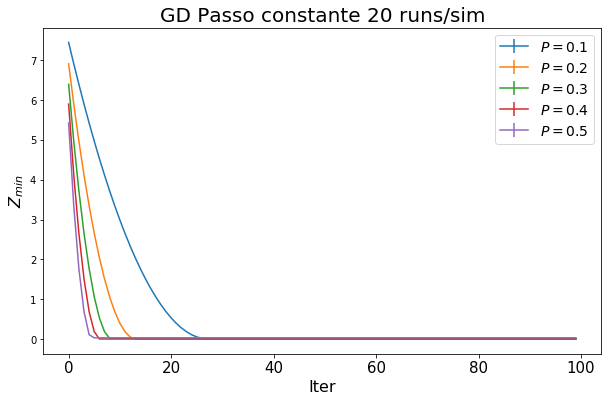

In [25]:
fig,axs = plt.subplots(figsize = (10,6))


print("Ponto Inicial - R mínimo encontrado")
axs.set_xlabel('Iter', fontsize = 16)
axs.set_ylabel('$Z_{min}$', fontsize = 16)
axs.set_title('GD Passo constante {} runs/sim'.format(20), fontsize = 20)

for i in [0.1,0.2,0.3,0.4,0.5]:
    xmin, ymin, zav, zstd = simul_gradiente_pconst(2,2,lambda _,k: i,g,100,20)
    axs.errorbar(np.arange(len(zav)), zav, zstd, label = '$P = {}$'.format(i))
    print('R = ({},{},{})'.format(xmin, ymin, zav[-1]))
    
plt.xticks(fontsize = 15)
plt.xticks(fontsize = 15)
#axs.set_yscale('log')
axs.legend(fontsize = 14)

R = (0.00030202280444346224,0.00030202280444346224,1.824355488077877e-07)
R = (-0.0004050839767424652,-0.0004050839767424652,3.281860564269801e-07)
R = (0.00030202280444384735,0.00030202280444384735,1.8243554880825285e-07)
R = (-0.001112190757929593,-0.001112190757929593,2.473936564048005e-06)
R = (0.0017162363668163823,0.0017162363668163823,5.89093453356619e-06)


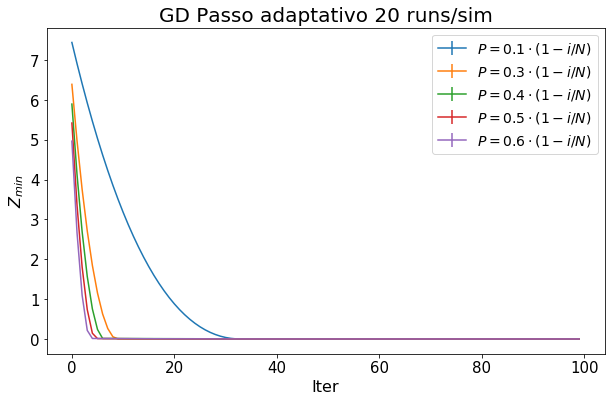

In [12]:
fig,axs = plt.subplots(figsize = (10,6))


axs.set_xlabel('Iter', fontsize = 16)
axs.set_ylabel('$Z_{min}$', fontsize = 16)
axs.set_title('GD Passo adaptativo {} runs/sim'.format(20), fontsize = 20)

for i in [0.1,0.3,0.4,0.5,0.6]:
    xmin, ymin, zav, zstd = simul_gradiente_pconst(2,2,lambda j,t: i*(1- (j/t)),g,100,20)
    axs.errorbar(np.arange(len(zav)), zav, zstd, label = '$P = {}\cdot(1 - i/N)$'.format(i))
    print('R = ({},{},{})'.format(xmin, ymin, zav[-1]))

#axs.set_yscale('log')
axs.legend(fontsize = 14)

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.show()

Ponto Inicial - R mínimo encontrado
R0 = (1.2100575292225555,-1.6341822511379394,4.134790853962459) | R min = (0.0008441370023829359,-0.0011400067133242875,2.012182585216492e-06)
R0 = (-1.4825231837798323,1.0810347829788514,3.3665111924548228) | R min = (0.0009651629138290457,-0.0007037830453551028,1.4268500251602774e-06)
R0 = (1.8176320712424197,-1.5439818723935543,5.687666368688914) | R min = (0.0006728873916649059,-0.0005715820882190026,7.794835254343965e-07)
R0 = (0.06185928455539935,0.6511236303875751,0.42778855313480146) | R min = (-0.0001839101775514716,-0.0019358171264541105,3.781210900480064e-06)
R0 = (0.2729898014619607,1.780917003012993,3.246188803323022) | R min = (0.00026034933619251827,0.0016984537776332242,2.952527011612454e-06)


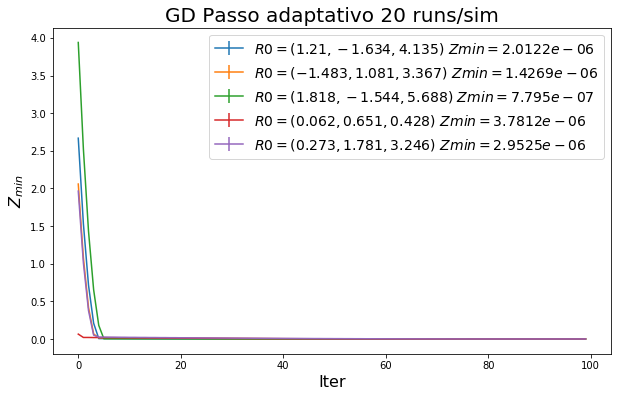

In [19]:
fig,axs = plt.subplots(figsize = (10,6))

print("Ponto Inicial - R mínimo encontrado")
axs.set_xlabel('Iter', fontsize = 16)
axs.set_ylabel('$Z_{min}$', fontsize = 16)
axs.set_title('GD Passo adaptativo {} runs/sim'.format(20), fontsize = 20)

x0 = [np.random.uniform(-2,2) for i in range(5)]
y0 = [np.random.uniform(-2,2) for i in range(5)]

for x,y in zip(x0,y0):
    xmin, ymin, zav, zstd = simul_gradiente_pconst(x,y,lambda j,t: 0.4*(1- (j/t)),g,100,20)
    axs.errorbar(np.arange(len(zav)), zav, zstd, label = '$R0 = ({},{},{})$ $Zmin = {}$'.format(np.round(x,3),np.round(y,3), np.round(g(x,y),3), np.round(zav[-1],10)))
    print('R0 = ({},{},{}) | R min = ({},{},{})'.format(x,y,g(x,y),xmin, ymin, zav[-1]))

#axs.set_yscale('log')
axs.legend(fontsize = 14)

### Comparativo BA e GD

Ponto Inicial - R mínimo encontrado
R0 = (-0.09982792054493395,-0.05907797934549475,0.013455821363872349) | R min = (6.626430852640919e-07,3.9215095628403196e-07,5.928782309627954e-13)
R0 = (-1.5382934552813938,-1.9220101579229927,6.060469801720737) | R min = (-0.0011260970139657517,-0.0014069941546057119,3.247727035957225e-06)
R0 = (-0.6004866513142488,0.604453426870128,0.7259481636616415) | R min = (-1.8265830789038207e-05,1.8386493672542525e-05,6.717037239842222e-10)


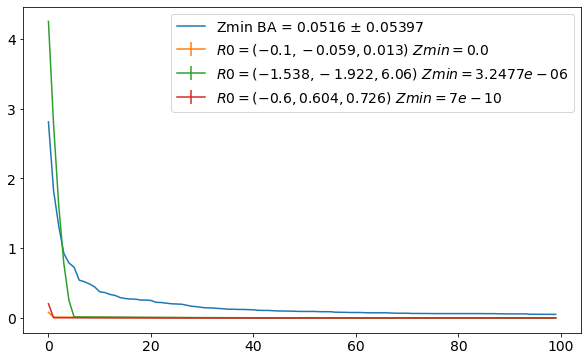

In [20]:
fig, axs = plt.subplots(figsize = (10,6))

print("Ponto Inicial - R mínimo encontrado")
zav, zstd = random_search([-2, 2],[-2,2],50, 100, g)
axs.plot(np.arange(len(zav)), zav, label ='Zmin BA = {} $\pm$ {}'.format(np.round(zav[-1],5),np.round(zstd[-1],5)))

x0 = [np.random.uniform(-2,2) for i in range(3)]
y0 = [np.random.uniform(-2,2) for i in range(3)]
for x,y in zip(x0,y0):
    xmin, ymin, zav, zstd = simul_gradiente_pconst(x,y,lambda j,t: 0.4*(1- (j/t)),g,100,20)
    axs.errorbar(np.arange(len(zav)), zav, zstd, label = '$R0 = ({},{},{})$ $Zmin = {}$'.format(np.round(x,3),np.round(y,3), np.round(g(x,y),3), np.round(zav[-1],10)))
    print('R0 = ({},{},{}) | R min = ({},{},{})'.format(x,y,g(x,y),xmin, ymin, zav[-1]))


#axs.set_yscale('log')
    
plt.legend(fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.show()

## 2
Seja o campo escalar $g(x,y) = -e^{-((x-1)^2+(y1)^2)/0.3^2}-.5e^{-16((x-2)^2 (y-2)^2)}$.
 Visualize este campo como uma superfície em 3D. Aplique descida de gradiente com
 simulated annealing para tentar obter o mínimo absoluto deste campo escalar. Incluir
 identificação de uma temperatura inicial adequada, que permita explorar os dois poços,
 assim como uma regra satisfatória de redução de temperatura.
 Comparar a curva de mínimo (média +- desvio padrão) entre este método e a busca
 aleatória (também apresentada como média +- desvio padrão).

In [15]:
def fexp(x,y): 
    return -np.exp(-((x-1)**2+(y-1)**2)/(0.3**2)) - 1.5*(np.exp(- 16*((x-2)**2+(y-2)**2)))

In [24]:
T = [20,75,100,150,500]
mn_av,mn_std,x,y = sas_search(fexp, 0.6, 5,T, 1000, 20)

R mínimo encontrado
T = 20 : r = (2.000511856809329,2.0011423318835964,-1.4751395912908507)
T = 75 : r = (2.0016316272953194,2.0004348833975496,-1.49185752075794)
T = 100 : r = (2.000368837060172,2.000781153010795,-1.4604663647340481)
T = 150 : r = (1.9999621600284632,2.000836843776233,-1.4632374113335607)
T = 500 : r = (1.99970539892659,2.000347189590224,-1.4983701391736859)


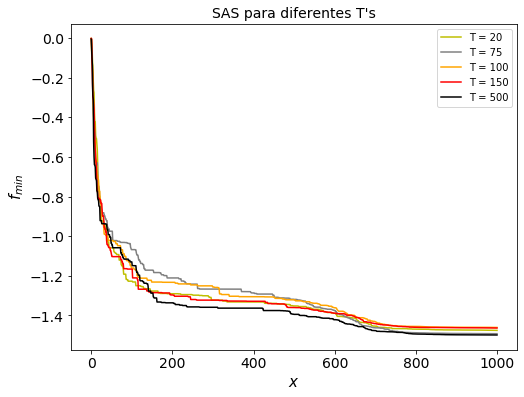

In [23]:
fig, axs = plt.subplots(figsize = (8,6))

print("R mínimo encontrado")
colors = ['y','gray','orange','red','black']
for av, std, xi, yi, T_, c in zip(mn_av, mn_std, x, y, T, colors):
    axs.plot(np.arange(len(av)),av, label = 'T = {}'.format(T_), color = c)
    print('T = {} : r = ({},{},{})'.format(T_,xi,yi,av[-1]) )

axs.set_ylabel('$f_{min}$', fontsize = 15)
axs.set_xlabel('$x$', fontsize = 15)
axs.set_title("SAS para diferentes T's", fontsize = 14)

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend()
plt.show()

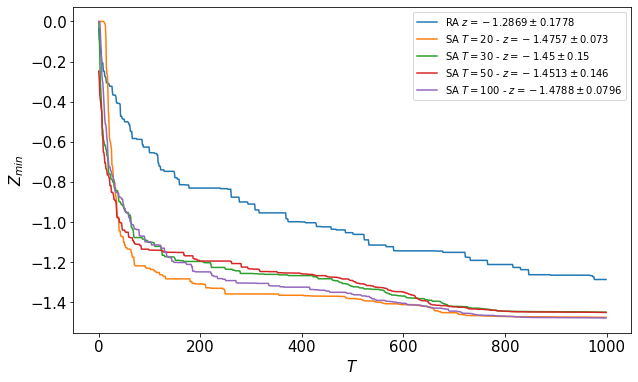

In [18]:
fig, axs = plt.subplots(figsize = (10,6))

xlim = [-1,5]
ylim = [-1,5]
N = 20
Nit = [1000]

avs_rsg,std_rsg = RS(fexp, xlim,ylim,N,Nit)


T = [20,30,50,100]

axs.plot(np.arange(1000),avs_rsg[0], label = 'RA $z = {}\pm {} $'.format(np.round(avs_rsg[0][-1], 4), np.round(std_rsg[0][-1], 4)))
for t in T:
    mn_av,mn_std,x,y = sas_search(fexp, 0.6, 5,T, 1000, 20)
    axs.plot(np.arange(1000),mn_av[0], label = 'SA $T = {}$ - $z = {}\pm {} $'.format(t,np.round(mn_av[0][-1], 4), np.round(mn_std[0][-1], 4)))
axs.set_ylabel('$Z_{min}$',fontsize = 15)
axs.set_xlabel('$T$',fontsize = 15)

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

axs.legend()
plt.show()